In [30]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib
%matplotlib inline
import os
import pickle

In [31]:
def undistort(img, objpoints, imgpoints):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

In [32]:
def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

In [33]:
def calibrate_camera(calibration_folder):

    #Initialize object and image points
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = []
    images = glob.glob(calibration_folder)
    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

        if ret == True:
            imgpoints.append(corners)
            objpoints.append(objp)
    return  objpoints, imgpoints

In [34]:
def magnitude_thresh(img):
    img = np.copy(img)

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = gaussian_blur(gray, 5)
    
    #magnitude
    abs_sobel_x = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=11))
    abs_sobel_y = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=11))
    abs_sobelxy = np.sqrt((abs_sobel_x * abs_sobel_x)+(abs_sobel_y * abs_sobel_y))
    scaled_mag = np.uint8(255*abs_sobelxy/np.max(abs_sobelxy))
    mag_binary = np.zeros_like(scaled_mag)
    mag_binary[(scaled_mag >= 60) & (scaled_mag <=255)] = 1
    
    return mag_binary

In [35]:
def direction_thresh(img):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=11)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=11)
    
    abs_grad_dir = np.arctan2(np.absolute(sobel_y), np.absolute(sobel_x))
    dir_binary =  np.zeros_like(abs_grad_dir)
    dir_binary[(abs_grad_dir >= .7) & (abs_grad_dir <= 1.1)] = 1
                                          
    return dir_binary

In [36]:
def channel_threshold_LUV(img,threshold_range):
    
    l_channel_luv = cv2.cvtColor(img, cv2.COLOR_BGR2LUV)[:,:,0]

    
    l_binary = np.zeros_like(l_channel_luv)
    l_binary[(l_channel_luv >= threshold_range[0]) & (l_channel_luv <= threshold_range[1])] = 1
    
    return l_binary

In [37]:
def channel_threshold_YCrCb(img,threshold_range):
    brightYCB = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)[:,:,0]
    
    ycrcb_binary = np.zeros_like(brightYCB)
    ycrcb_binary[(brightYCB >= threshold_range[0]) & (brightYCB <= threshold_range[1])] = 1
    
    return ycrcb_binary

In [38]:
def channel_threshold_LAB(img,threshold_range):
    
    b_channel_lab = cv2.cvtColor(img, cv2.COLOR_BGR2Lab)[:,:,2]
        
    b_binary = np.zeros_like(b_channel_lab)
    b_binary[(b_channel_lab >= threshold_range[0]) & (b_channel_lab <= threshold_range[1])] = 1
    
    return b_binary

In [39]:
def sobel_x(img):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    
    abs_sobelx = np.absolute(sobel_x)
    scaled_sobelx = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    sobel_x_binary = np.zeros_like(scaled_sobelx)
    sobel_x_binary[(scaled_sobelx >= 15) & (scaled_sobelx <= 255)] = 1
    
    return sobel_x_binary


def sobel_y(img):  
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    
    abs_sobely = np.absolute(sobel_y)
    scaled_sobely = np.uint8(255*abs_sobely/np.max(abs_sobely))
    sobel_y_binary = np.zeros_like(scaled_sobely)
    sobel_y_binary[(scaled_sobely >= 35) & (scaled_sobely <= 255)] = 1
    
    return sobel_y_binary

In [40]:
def color_threshold(img):
    
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel > 60) & (s_channel <= 255)] = 1
    
    
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    v_channel = hsv[:,:,2]
    v_binary = np.zeros_like(v_channel)
    v_binary[(v_channel >120) & (v_channel <= 255)] = 1 
    
    
    color_binary = np.zeros_like(s_channel)
    color_binary[(s_binary == 1) & (v_binary == 1)] = 1
    return color_binary

In [41]:
def threshold_video_hard(img):
    sobel_x_binary = sobel_x(img)
    sobel_y_binary = sobel_y(img)
    
    mag_binary = magnitude_thresh(img)
    dir_binary = direction_thresh(img)
    
    color_binary = color_threshold(img)
#     img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
#     binary_output = np.zeros_like(img)
    binary_output = np.zeros_like(sobel_x_binary)
    binary_output[(sobel_x_binary == 1) & (sobel_y_binary == 1) & (mag_binary == 1) | (color_binary == 1) | (mag_binary == 1) & (dir_binary == 1)] = 1
    return binary_output

In [42]:

calibration_folder ='camera_cal/calibration*.jpg'
objpoints, imgpoints = calibrate_camera(calibration_folder)


In [43]:
# folder = "test_images/"
# image_list = os.listdir(folder)
# for i, image in enumerate(image_list):
#     image_file = os.path.join(folder, image)
#     img = cv2.imread(image_file)

#     f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
#     f.tight_layout()
    
#     ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
#     undistorted = cal_undistort(img, objpoints, imgpoints)
#     ax1.set_title('Original Image - '+ image, fontsize=15)
#     ax2.imshow(cv2.cvtColor(undistorted, cv2.COLOR_BGR2RGB))
#     ax2.set_title('Undistorted Image', fontsize=15)
#     #result = pipeline1(undistorted, s_thresh=(150, 255), sobel_x_thresh=(100, 250), mag_thresh= (50,255))
#     result = magnitude_thresh(undistorted, mag_thresh= (50,255))
#     #ax3.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
#     ax3.imshow(result, cmap = 'gray')
#     ax3.set_title('Magnitude Threshold', fontsize=15)
#     plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [44]:
# folder = "test_images/"
# image_list = os.listdir(folder)
# for i, image in enumerate(image_list):
#     image_file = os.path.join(folder, image)
#     img = cv2.imread(image_file)

#     f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
#     f.tight_layout()
    
#     ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
#     undistorted = cal_undistort(img, objpoints, imgpoints)
#     ax1.set_title('Original Image - '+ image, fontsize=15)
#     ax2.imshow(cv2.cvtColor(undistorted, cv2.COLOR_BGR2RGB))
#     ax2.set_title('Undistorted Image', fontsize=15)
#     result = sobel_output(undistorted, s_thresh=(100, 255))
#     #ax3.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
#     ax3.imshow(result, cmap = 'gray')
#     ax3.set_title('Sobel Output', fontsize=15)
#     plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [45]:
# folder = "test_images/"
# image_list = os.listdir(folder)
# for i, image in enumerate(image_list):
#     image_file = os.path.join(folder, image)
#     img = cv2.imread(image_file)

#     f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
#     f.tight_layout()
    
#     ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
#     undistorted = cal_undistort(img, objpoints, imgpoints)
#     ax1.set_title('Original Image - '+ image, fontsize=15)
#     ax2.imshow(cv2.cvtColor(undistorted, cv2.COLOR_BGR2RGB))
#     ax2.set_title('Undistorted Image', fontsize=15)
#     result = channel_threshold_YCrCb(undistorted, (220,255))
#     #ax3.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
#     ax3.imshow(result, cmap = 'gray')
#     ax3.set_title('YCrCb Output', fontsize=15)
#     plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [46]:
# folder = "test_images/"
# image_list = os.listdir(folder)
# for i, image in enumerate(image_list):
#     image_file = os.path.join(folder, image)
#     img = cv2.imread(image_file)

#     f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
#     f.tight_layout()
    
#     ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
#     undistorted = cal_undistort(img, objpoints, imgpoints)
#     ax1.set_title('Original Image - '+ image, fontsize=15)
#     ax2.imshow(cv2.cvtColor(undistorted, cv2.COLOR_BGR2RGB))
#     ax2.set_title('Undistorted Image', fontsize=15)
#     result = channel_threshold_LUV(undistorted, (215,255))
#     #ax3.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
#     ax3.imshow(result, cmap = 'gray')
#     ax3.set_title('LUV Output', fontsize=15)
#     plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [47]:
# folder = "test_images/"
# image_list = os.listdir(folder)
# for i, image in enumerate(image_list):
#     image_file = os.path.join(folder, image)
#     img = cv2.imread(image_file)

#     f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
#     f.tight_layout()
    
#     ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
#     undistorted = cal_undistort(img, objpoints, imgpoints)
#     ax1.set_title('Original Image - '+ image, fontsize=15)
#     ax2.imshow(cv2.cvtColor(undistorted, cv2.COLOR_BGR2RGB))
#     ax2.set_title('Undistorted Image', fontsize=15)
#     result = channel_threshold_LAB(undistorted, (160,215))
#     #ax3.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
#     ax3.imshow(result, cmap = 'gray')
#     ax3.set_title('LAB Output', fontsize=15)
#     plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [48]:
# folder = "test_images/"
# image_list = os.listdir(folder)
# for i, image in enumerate(image_list):
#     image_file = os.path.join(folder, image)
#     img = cv2.imread(image_file)

#     f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
#     f.tight_layout()
    
#     ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
#     undistorted = cal_undistort(img, objpoints, imgpoints)
#     ax1.set_title('Original Image - '+ image, fontsize=15)
#     ax2.imshow(cv2.cvtColor(undistorted, cv2.COLOR_BGR2RGB))
#     ax2.set_title('Undistorted Image', fontsize=15)
#     result_lab = channel_threshold_LAB(undistorted, (160,215))
#     result_luv = channel_threshold_LUV(undistorted, (215,255))
#     pipeline_output = np.zeros_like(result_lab)
#     pipeline_output[(result_lab == 1) | (result_luv == 1)] = 1
    
#     ax3.imshow(pipeline_output, cmap = 'gray')
#     ax3.set_title('Thresholded Output', fontsize=15)
#     plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    

In [49]:
def transform_prespective(img):
    img_size = (img.shape[1], img.shape[0])
    src1 = (592, 450)         # top right
    scr2 = (180, img.shape[0])      # bottom left
    src3 = (1130, img.shape[0])     # bottom right
    src4 = (687, 450)         # top left
    src_points = np.array([[src1, scr2, src3, src4]]).astype('float32')
    
    dst1 = (240, 0)           # top right
    dst2 = (240, img.shape[0])      # bottom left
    dst3 = (1040, img.shape[0])     # bottom right
    dst4 = (1040, 0)          # top left 
    dst_points = np.array([[dst1, dst2, dst3, dst4]]).astype('float32')
    M = cv2.getPerspectiveTransform(src_points, dst_points)
    Minv = cv2.getPerspectiveTransform(dst_points, src_points)
    return cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR),Minv

In [50]:
def find_lane_pixels_vid(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 10
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 2

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]

        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    return leftx, lefty, rightx, righty,leftx_current,rightx_current, out_img,leftx_base,rightx_base

In [51]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 10
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 2

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
#         cv2.rectangle(out_img,(win_xleft_low,win_y_low),
#         (win_xleft_high,win_y_high),(0,255,0), 2) 
#         cv2.rectangle(out_img,(win_xright_low,win_y_low),
#         (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]

        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    return leftx, lefty, rightx, righty, out_img


def fit_polynomial_pics(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    

    return out_img, left_fit, right_fit

In [52]:
def fit_polynomial_vid(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty,leftx_current,rightx_current, out_img,leftx_base,right_base = find_lane_pixels_vid(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty
    

    return out_img, left_fit, right_fit,left_fitx,right_fitx,leftx_current,rightx_current

In [53]:
def center_offset_calc(binary_warped,left_fit,right_fit):
    
    bottom_y = binary_warped.shape[0] - 1
    bottom_x_left = left_fit[0]*(bottom_y**2) + left_fit[1]*bottom_y + left_fit[2]
    bottom_x_right = right_fit[0]*(bottom_y**2) + right_fit[1]*bottom_y + right_fit[2]
    offset = binary_warped.shape[1]/2 - (bottom_x_left + bottom_x_right)/2

    #pixel meter converstion
    offset *= 3.7/700
    
    return offset

In [54]:
def curve_radius(leftx,lefty,rightx,righty, y_max):


    # Define conversions in x and y from pixels space to meters
    y_pix2m = 30/720 # meters per pixel in y dimension
    x_pix2m = 3.7/700 # meters per pixel in x dimension



    # Fit new polynomials to x,y in world space
    left_curve_m = np.polyfit(lefty*y_pix2m, leftx*x_pix2m, 2)
    right_curve_m = np.polyfit(righty*y_pix2m, rightx*x_pix2m, 2)
    
    # Calculate the new radii of curvature
    left_curve_radius = ((1 + (2*left_curve_m[0]*y_max*y_pix2m + left_curve_m[1])**2)**1.5) / np.absolute(2*left_curve_m[0])
    right_curve_radius = ((1 + (2*right_curve_m[0]*y_max*y_pix2m + right_curve_m[1])**2)**1.5) / np.absolute(2*right_curve_m[0])


    return left_curve_radius, right_curve_radius

In [55]:
def Lane_Area(binary_warped, undistorted, left_fit, right_fit, m_inv):
    
    
    # find lane pixels 
    leftx,lefty,rightx,righty,out_img = find_lane_pixels(binary_warped)
    
    #find curve radius
    left_curve_radius, right_curve_radius = curve_radius(leftx,lefty,rightx,righty,undistorted.shape[0]-1 )
    avg_radius = (left_curve_radius + right_curve_radius)/2
    
    #find offset
    center_offset = center_offset_calc(binary_warped, left_fit,right_fit)
    
    #create lane area mask
    temp_lane_area = np.zeros_like(undistorted)

    # Recast the x and y points into usable format for cv2.fillPoly()
    ploty = np.linspace(0, undistorted.shape[0]-1, undistorted.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

     #fill green color
    cv2.fillPoly(temp_lane_area, np.int_([pts]), (0,255, 0))

    # Highlight lane area mask in undistorted
    inverse_transformed = cv2.warpPerspective(temp_lane_area, m_inv, (undistorted.shape[1], undistorted.shape[0]))
    
    # Combine the result with the original image
    lane_area = cv2.addWeighted(undistorted, 1, inverse_transformed, 0.3, 0)

    # Write text in image
    radius_text = 'Radius of curve is ' + str(round(avg_radius, 2)) + ' m' 
    offset_text = 'Offset from lane center:'+ str(abs(round(center_offset, 2)))
    
                      
    lane_area = cv2.putText(lane_area, radius_text, (450,40), 0, 1, (0,0,0), 2, cv2.LINE_AA)
    lane_area = cv2.putText(lane_area, offset_text, (450,70), 0, 1, (0,0,0), 2, cv2.LINE_AA)

    return lane_area


In [56]:
def Lane_Area_Vid(binary_warped, undistorted, left_fit, right_fit, m_inv,avg_radius):
    
    
    # find lane pixels 
    leftx,lefty,rightx,righty,out_img = find_lane_pixels(binary_warped)
    
    #find offset
    center_offset = center_offset_calc(binary_warped, left_fit,right_fit)
    
    #create lane area mask
    temp_lane_area = np.zeros_like(undistorted)

    # Recast the x and y points into usable format for cv2.fillPoly()
    ploty = np.linspace(0, undistorted.shape[0]-1, undistorted.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

     #fill green color
    cv2.fillPoly(temp_lane_area, np.int_([pts]), (0,255, 0))

    # Highlight lane area mask in undistorted
    inverse_transformed = cv2.warpPerspective(temp_lane_area, m_inv, (undistorted.shape[1], undistorted.shape[0]))
    
    # Combine the result with the original image
    lane_area = cv2.addWeighted(undistorted, 1, inverse_transformed, 0.3, 0)

    # Write text in image
    radius_text = 'Radius of curve is ' + str(round(avg_radius, 2)) + ' m' 
    offset_text = 'Offset from lane center:'+ str(abs(round(center_offset, 2)))
    
                      
    lane_area = cv2.putText(lane_area, radius_text, (450,40), 0, 1, (0,0,0), 2, cv2.LINE_AA)
    lane_area = cv2.putText(lane_area, offset_text, (450,70), 0, 1, (0,0,0), 2, cv2.LINE_AA)

    return lane_area

In [57]:
# folder = "test_images/"
# image_list = os.listdir(folder)
# for i, image in enumerate(image_list):
#     image_file = os.path.join(folder, image)
#     img = cv2.imread(image_file)

#     f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
#     f.tight_layout()
    
#     ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
#     undistorted = cal_undistort(img, objpoints, imgpoints)
#     ax1.set_title('Original Image - '+ image, fontsize=15)
#     ax2.imshow(cv2.cvtColor(undistorted, cv2.COLOR_BGR2RGB))
#     ax2.set_title('Undistorted Image', fontsize=15)
#     result_lab = channel_threshold_LAB(undistorted, (160,215))
#     result_luv = channel_threshold_LUV(undistorted, (215,255))
#     pipeline_output = np.zeros_like(result_lab)
#     pipeline_output[(result_lab == 1) | (result_luv == 1)] = 1

#     # Get perspective transform matrix and its inverse
#     img_size = (pipeline_output.shape[1], pipeline_output.shape[0])
#     warped_image, m_inv = transform_prespective(pipeline_output)
    
#     #find the polynomial curve
#     out_img, left_fit, right_fit  = fit_polynomial_pics(warped_image)

#     #ax3.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
#     ax3.imshow(out_img, cmap = 'gray')
#     ax3.set_title('Lane Curve', fontsize=15)
#     plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

error: /feedstock_root/build_artefacts/opencv_1496434080029/work/opencv-3.2.0/modules/imgproc/src/color.cpp:9716: error: (-215) scn == 3 || scn == 4 in function cvtColor


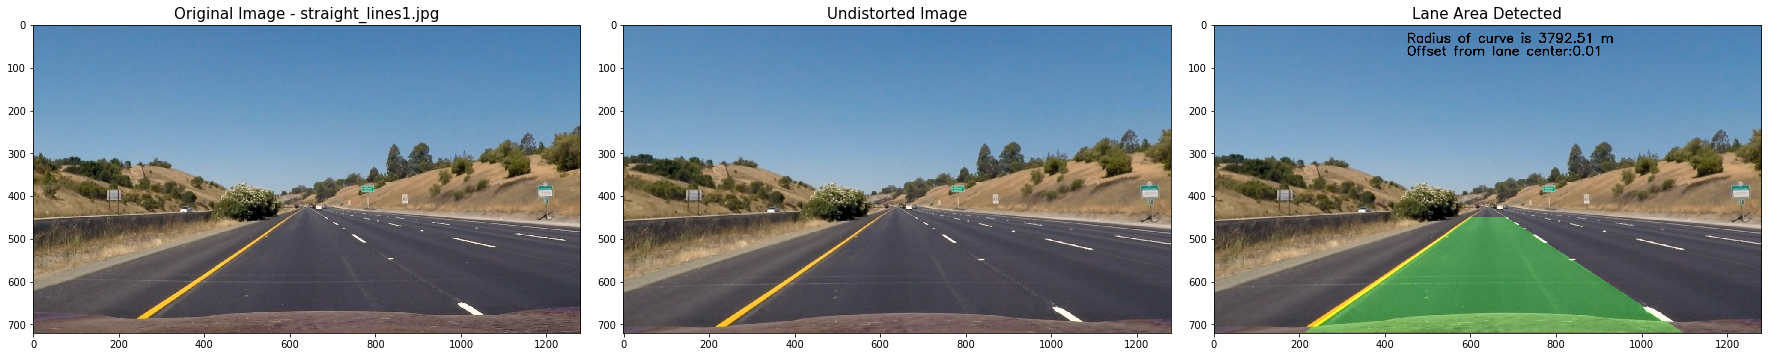

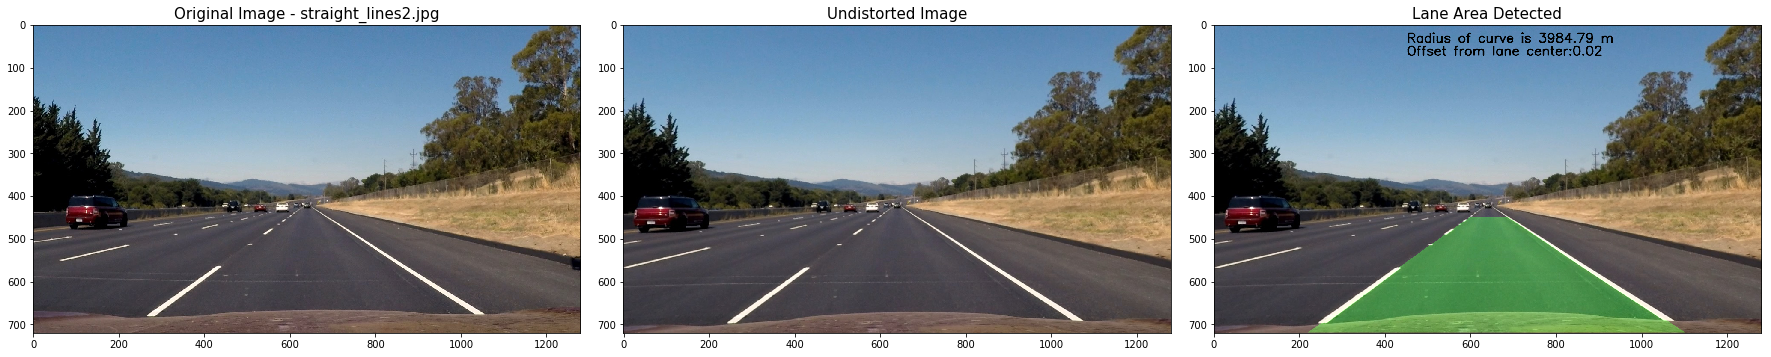

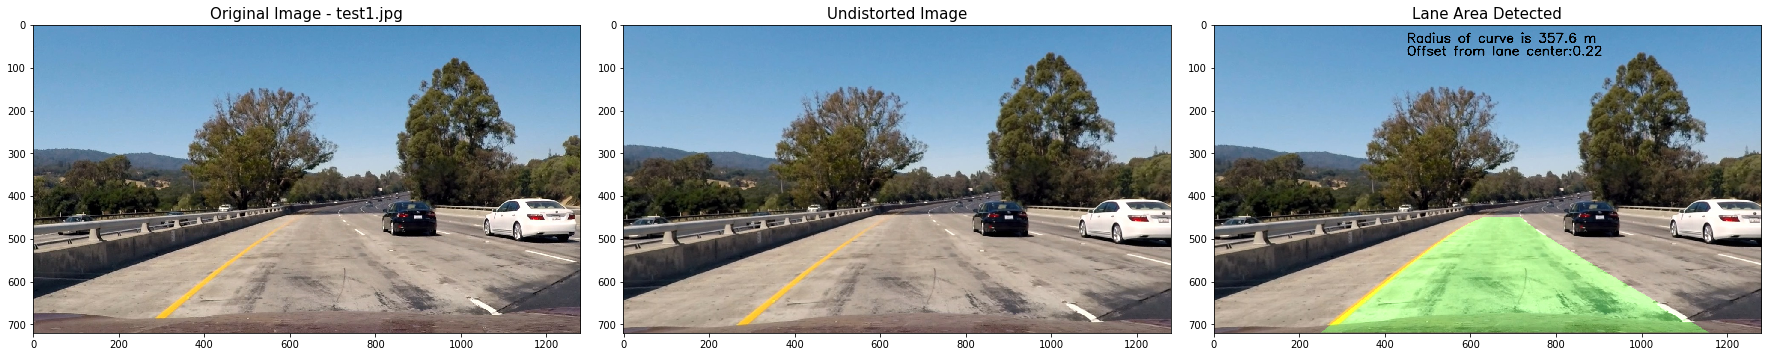

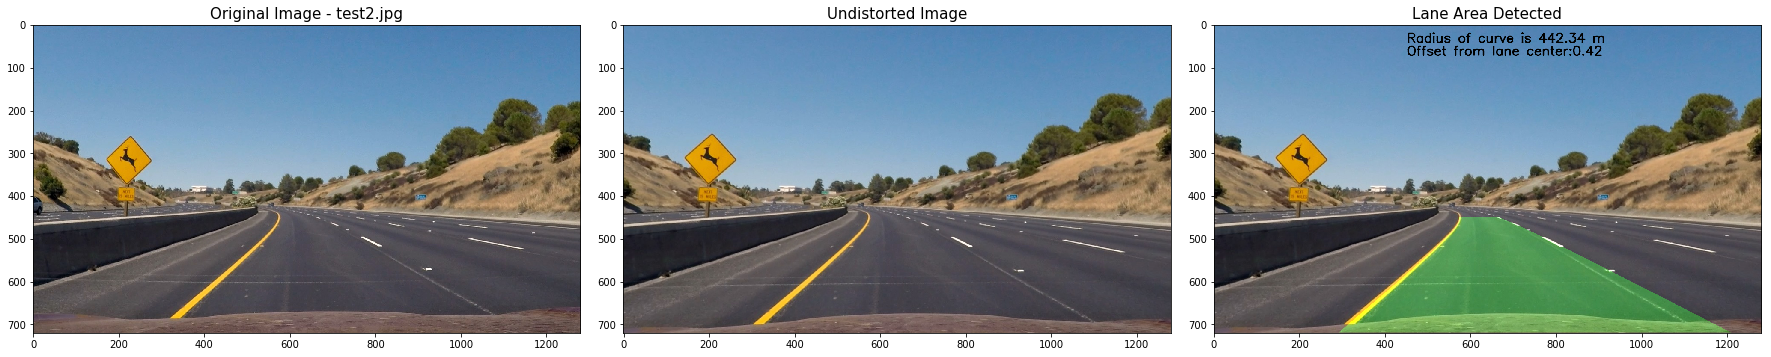

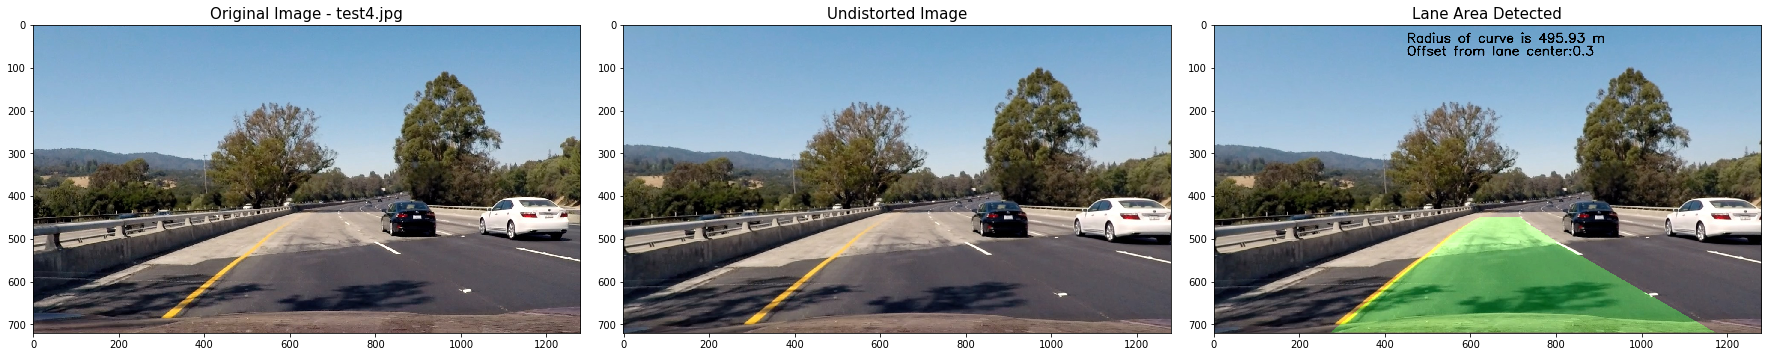

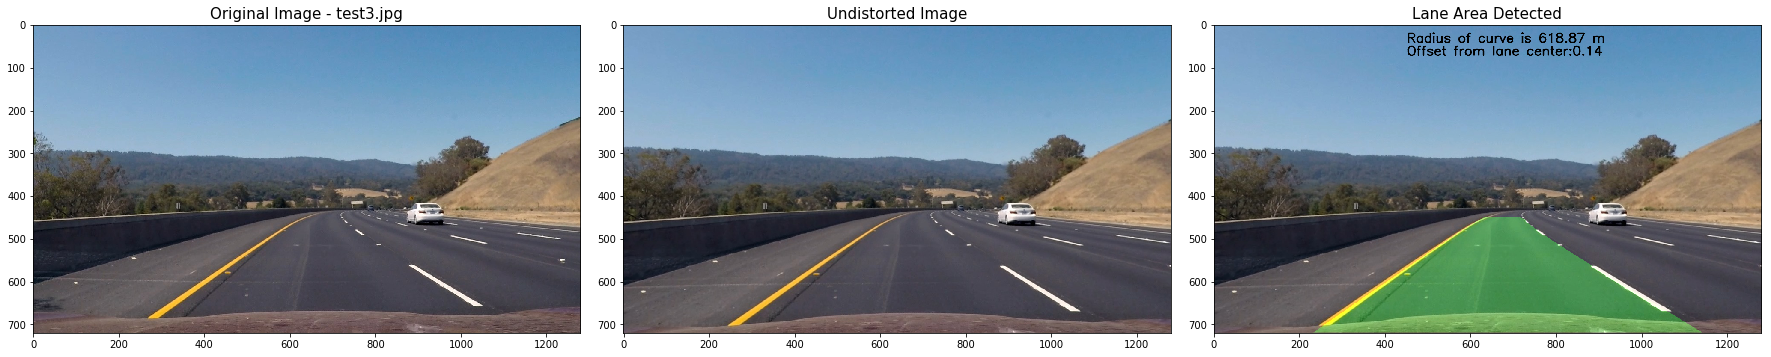

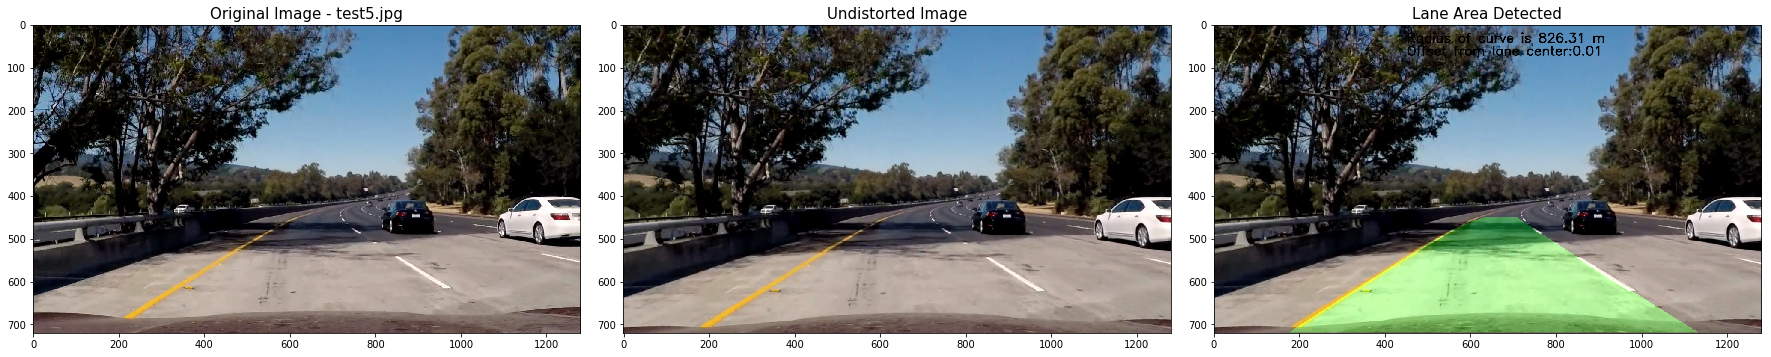

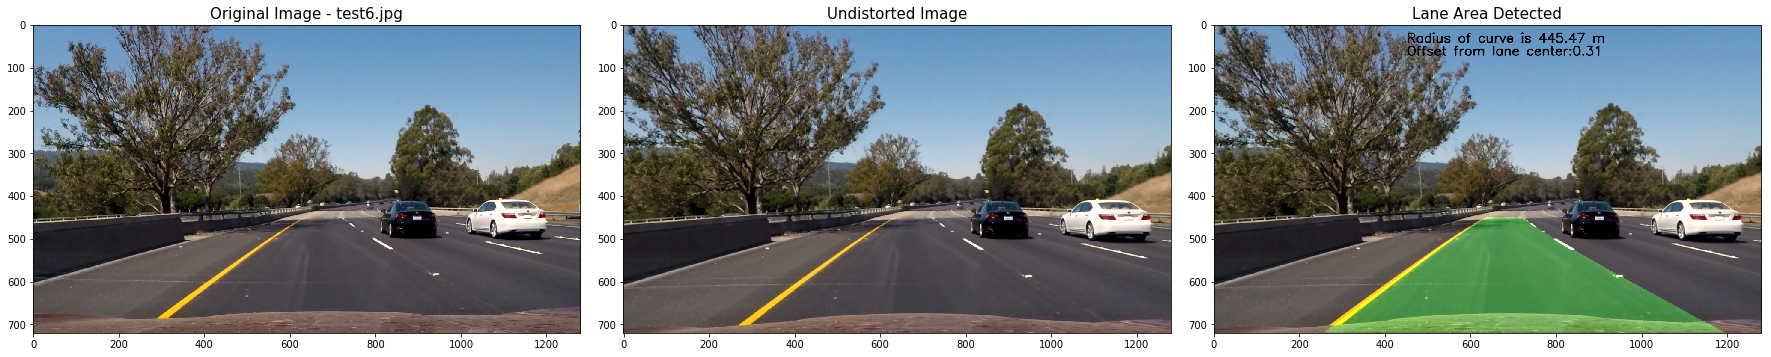

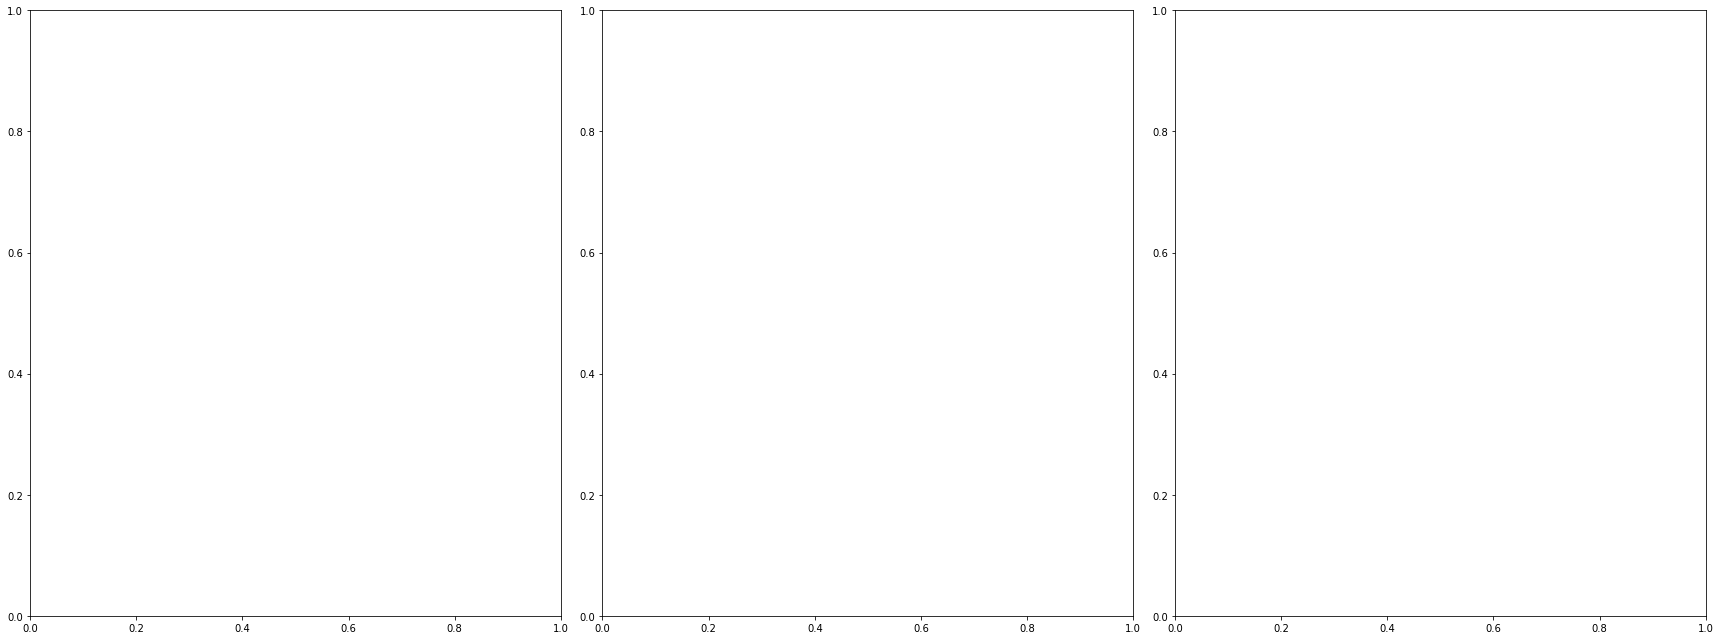

In [59]:
folder = "test_images/"
image_list = os.listdir(folder)
for i, image in enumerate(image_list):
    image_file = os.path.join(folder, image)
    img = cv2.imread(image_file)

    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
    f.tight_layout()
    
    ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    undistorted = undistort(img, objpoints, imgpoints)
    ax1.set_title('Original Image - '+ image, fontsize=15)
    ax2.imshow(cv2.cvtColor(undistorted, cv2.COLOR_BGR2RGB))
    ax2.set_title('Undistorted Image', fontsize=15)
    result_lab = channel_threshold_LAB(undistorted, (160,215))
    result_luv = channel_threshold_LUV(undistorted, (215,255))
    pipeline_output = np.zeros_like(result_lab)
    pipeline_output[(result_lab == 1) | (result_luv == 1)] = 1

    # Get perspective transform matrix and its inverse
    img_size = (pipeline_output.shape[1], pipeline_output.shape[0])
    warped_image, m_inv = transform_prespective(pipeline_output)
    
    #find the polynomial curve
    out_img, left_fit, right_fit,_,_ ,_,_ = fit_polynomial_vid(warped_image)
    
    # lane area detected
    lane_area = Lane_Area(warped_image, undistorted, left_fit, right_fit, m_inv)

    ax3.imshow(cv2.cvtColor(lane_area, cv2.COLOR_BGR2RGB))
    #ax3.imshow(warped_image, cmap = 'gray')
    ax3.set_title('Lane Area Detected', fontsize=15)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [ ]:
# folder = "test_images/"
# image_list = os.listdir(folder)
# for i, image in enumerate(image_list):
#     image_file = os.path.join(folder, image)
#     img = cv2.imread(image_file)

#     f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
#     f.tight_layout()
    
#     ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
#     undistorted = cal_undistort(img, objpoints, imgpoints)
#     ax1.set_title('Original Image - '+ image, fontsize=15)
#     ax2.imshow(cv2.cvtColor(undistorted, cv2.COLOR_BGR2RGB))
#     ax2.set_title('Undistorted Image', fontsize=15)
    
#     lane_area = preprocessing_video(img)

#     ax3.imshow(cv2.cvtColor(lane_area, cv2.COLOR_BGR2RGB))
#     #ax3.imshow(warped_image, cmap = 'gray')
#     ax3.set_title('Lane Area Detected', fontsize=15)
#     plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [ ]:
def sliding_windows(binary_warped):
    
    leftx, lefty, rightx, righty,leftx_current,rightx_current, out_img,leftx_base,rightx_base = find_lane_pixels_vid(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty
    
    
    #Retaing for next frame
    LEFT.recent_xfits = [(left_fitx)]
    LEFT.best_xfit = np.mean(LEFT.recent_xfits)
    RIGHT.recent_xfits = [(right_fitx)]
    RIGHT.best_xfit = np.mean(RIGHT.recent_xfits)
        
    LEFT.current_fit_coeffs = [(left_fit)]
    LEFT.best_fit_coeffs = np.mean(LEFT.current_fit_coeffs)
    RIGHT.current_fit_coeffs = [(right_fit)]
    RIGHT.best_fit_coeffs = np.mean(RIGHT.current_fit_coeffs)
    
    LEFT.line_base_position = leftx_current
    RIGHT.line_base_position = rightx_current
        
    LEFT.allx = leftx
    LEFT.ally = lefty
    RIGHT.allx = rightx
    RIGHT.ally = righty
    
    return out_img, ploty, left_fitx, right_fitx, left_fit, right_fit, leftx, rightx,lefty,righty, leftx_base, rightx_base

In [ ]:
def region_of_interest_left(img):
    width = img.shape[1]
    height = img.shape[0]
    vertices = np.array([[(width*0.49, height*0.55),
                        (width*0.49, height*0.55),
                        (width*0.3, height),
                        (width*0.15, height)]], 
                        dtype=np.int32)
    mask = np.zeros_like(img)   
    if len(img.shape) > 2:
        channel_count = img.shape[2]
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    masked_image_left = cv2.bitwise_and(img, mask)
    return masked_image_left

def region_of_interest_right(img):
    width = img.shape[1]
    height = img.shape[0]
    vertices = np.array([[(width*0.51, height*0.55),
                        (width*0.51, height*0.55),
                        (width*0.95, height),
                        (width*0.8, height)]], 
                        dtype=np.int32)
    mask = np.zeros_like(img)   
    if len(img.shape) > 2:
        channel_count = img.shape[2]
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    masked_image_right = cv2.bitwise_and(img, mask)
    return masked_image_right

def region_of_interest(img):
    mask_left = region_of_interest_left(img)
    mask_right = region_of_interest_right(img)
    masked_image = cv2.addWeighted(mask_left, 1.0, mask_right, 1.0, 0)
    return masked_image



In [ ]:
class Line():
    
    def __init__(self):
        
        self.detected = False
        
        self.recent_xfits = []
        self.best_xfit = None
        
        self.current_fit_coeffs = [np.array([False])]
        self.best_fit_coeffs = None
                
        self.radius_of_curvature = None
        self.line_base_position = None
        
        self.allx = None
        self.ally = None
        
    

In [ ]:
LEFT = Line()
RIGHT = Line()


In [ ]:
def video_pipeline(img):
        
        undistorted = undistort(img, objpoints, imgpoints)
        thresholded = threshold_video_hard(undistorted)
        warped_image, m_inv = transform_prespective(thresholded)
        windows_img, ploty, left_fitx, right_fitx, left_fit, right_fit, leftx, rightx,lefty,righty, leftx_base, rightx_base = sliding_windows(warped_image)   
        
        left_curve_radius, right_curve_radius = curve_radius(leftx,lefty,rightx,righty,undistorted.shape[0]-1 )
        avg_radius = (left_curve_radius + right_curve_radius)/2
        
        out_img = Lane_Area_Vid(warped_image, undistorted, left_fit, right_fit, m_inv,avg_radius)
        
        return out_img

In [ ]:
from moviepy.editor import VideoFileClip

video_output = 'P4_video_final_p_copy.mp4'
clip = VideoFileClip('project_video.mp4')

output_clip = clip.fl_image(video_pipeline)
%time output_clip.write_videofile(video_output, audio=False)

In [ ]:
clip.reader.close()
clip.audio.reader.close_proc()